In [1]:
library(phangorn)
library(phytools)
library(furrr)
library(tidyverse)
library(glue)

devtools::load_all(".")

plan(multiprocess)

Loading required package: ape
Loading required package: maps
Loading required package: future
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::map()    masks maps::map()

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse

Loading ychr


In [8]:
est_df <- future_map_dfr(1:50, function(i) {
    step1 <- read_simgt(glue("../test/out_{i}.snp.gz")) %>% run_step1
    step2 <- run_step2(read_simgt(glue("../test/out_{i}.snp.gz")), step1) %>% mutate(rep = i)
}) %>%
    select(arch, afr, ref, tmrca_afr, tmrca_mendez, tmrca_new, rep) %>%
    gather(tmrca, value, -c(arch, afr, ref, rep)) %>%
    mutate(set = ifelse(tmrca == "tmrca_afr", "afr", "arch"))

In [9]:
true_df <-
    future_map_dfr(1:50, ~read_tsv(glue("../test/out_{.x}.txt"), col_types = "nn") %>% mutate(rep = .x)) %>%
    gather(tmrca, value, -rep) %>%
    mutate(set = ifelse(tmrca == "tmrca_afr", "afr", "arch"))

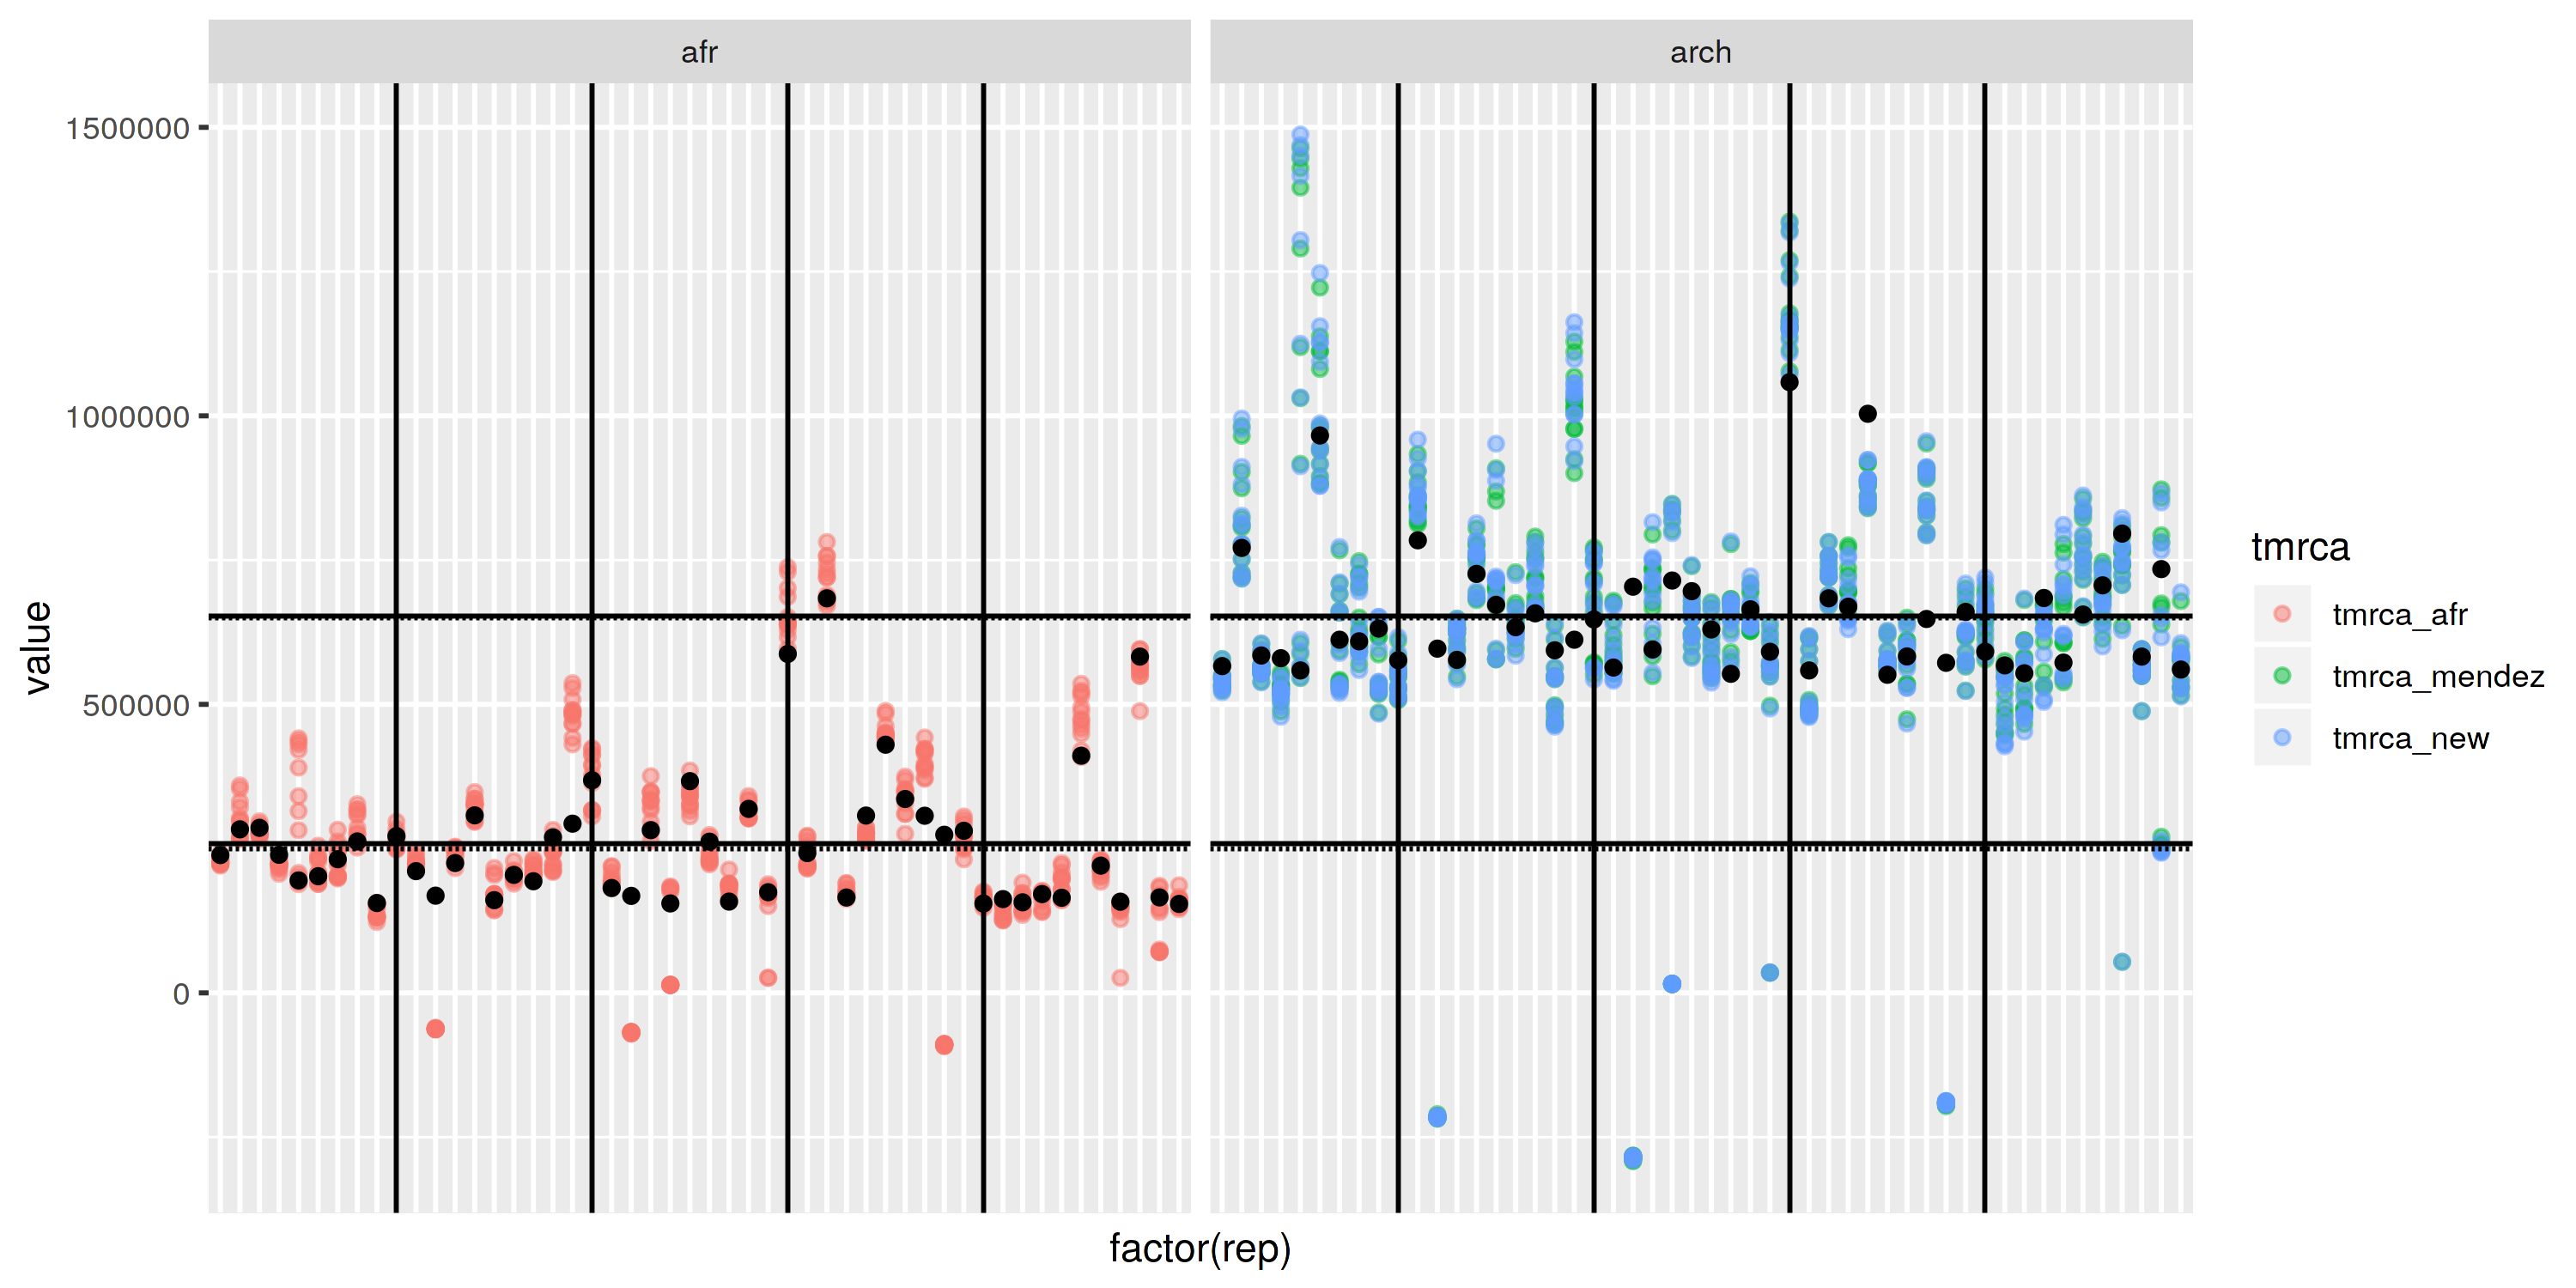

In [15]:
set_dim(10, 5)

est_df %>%
ggplot(aes(factor(rep), value, color = tmrca)) +
    geom_point(alpha = 1/2) +
    geom_point(data = true_df, aes(factor(rep), value), color = "black") +
    geom_hline(yintercept = c(250000, 650000), linetype = 2) +
    geom_hline(yintercept = true_df %>% group_by(set) %>% summean %>% .$value) +
    facet_wrap(~ set) +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
    geom_vline(xintercept = c(10, 20, 30, 40))

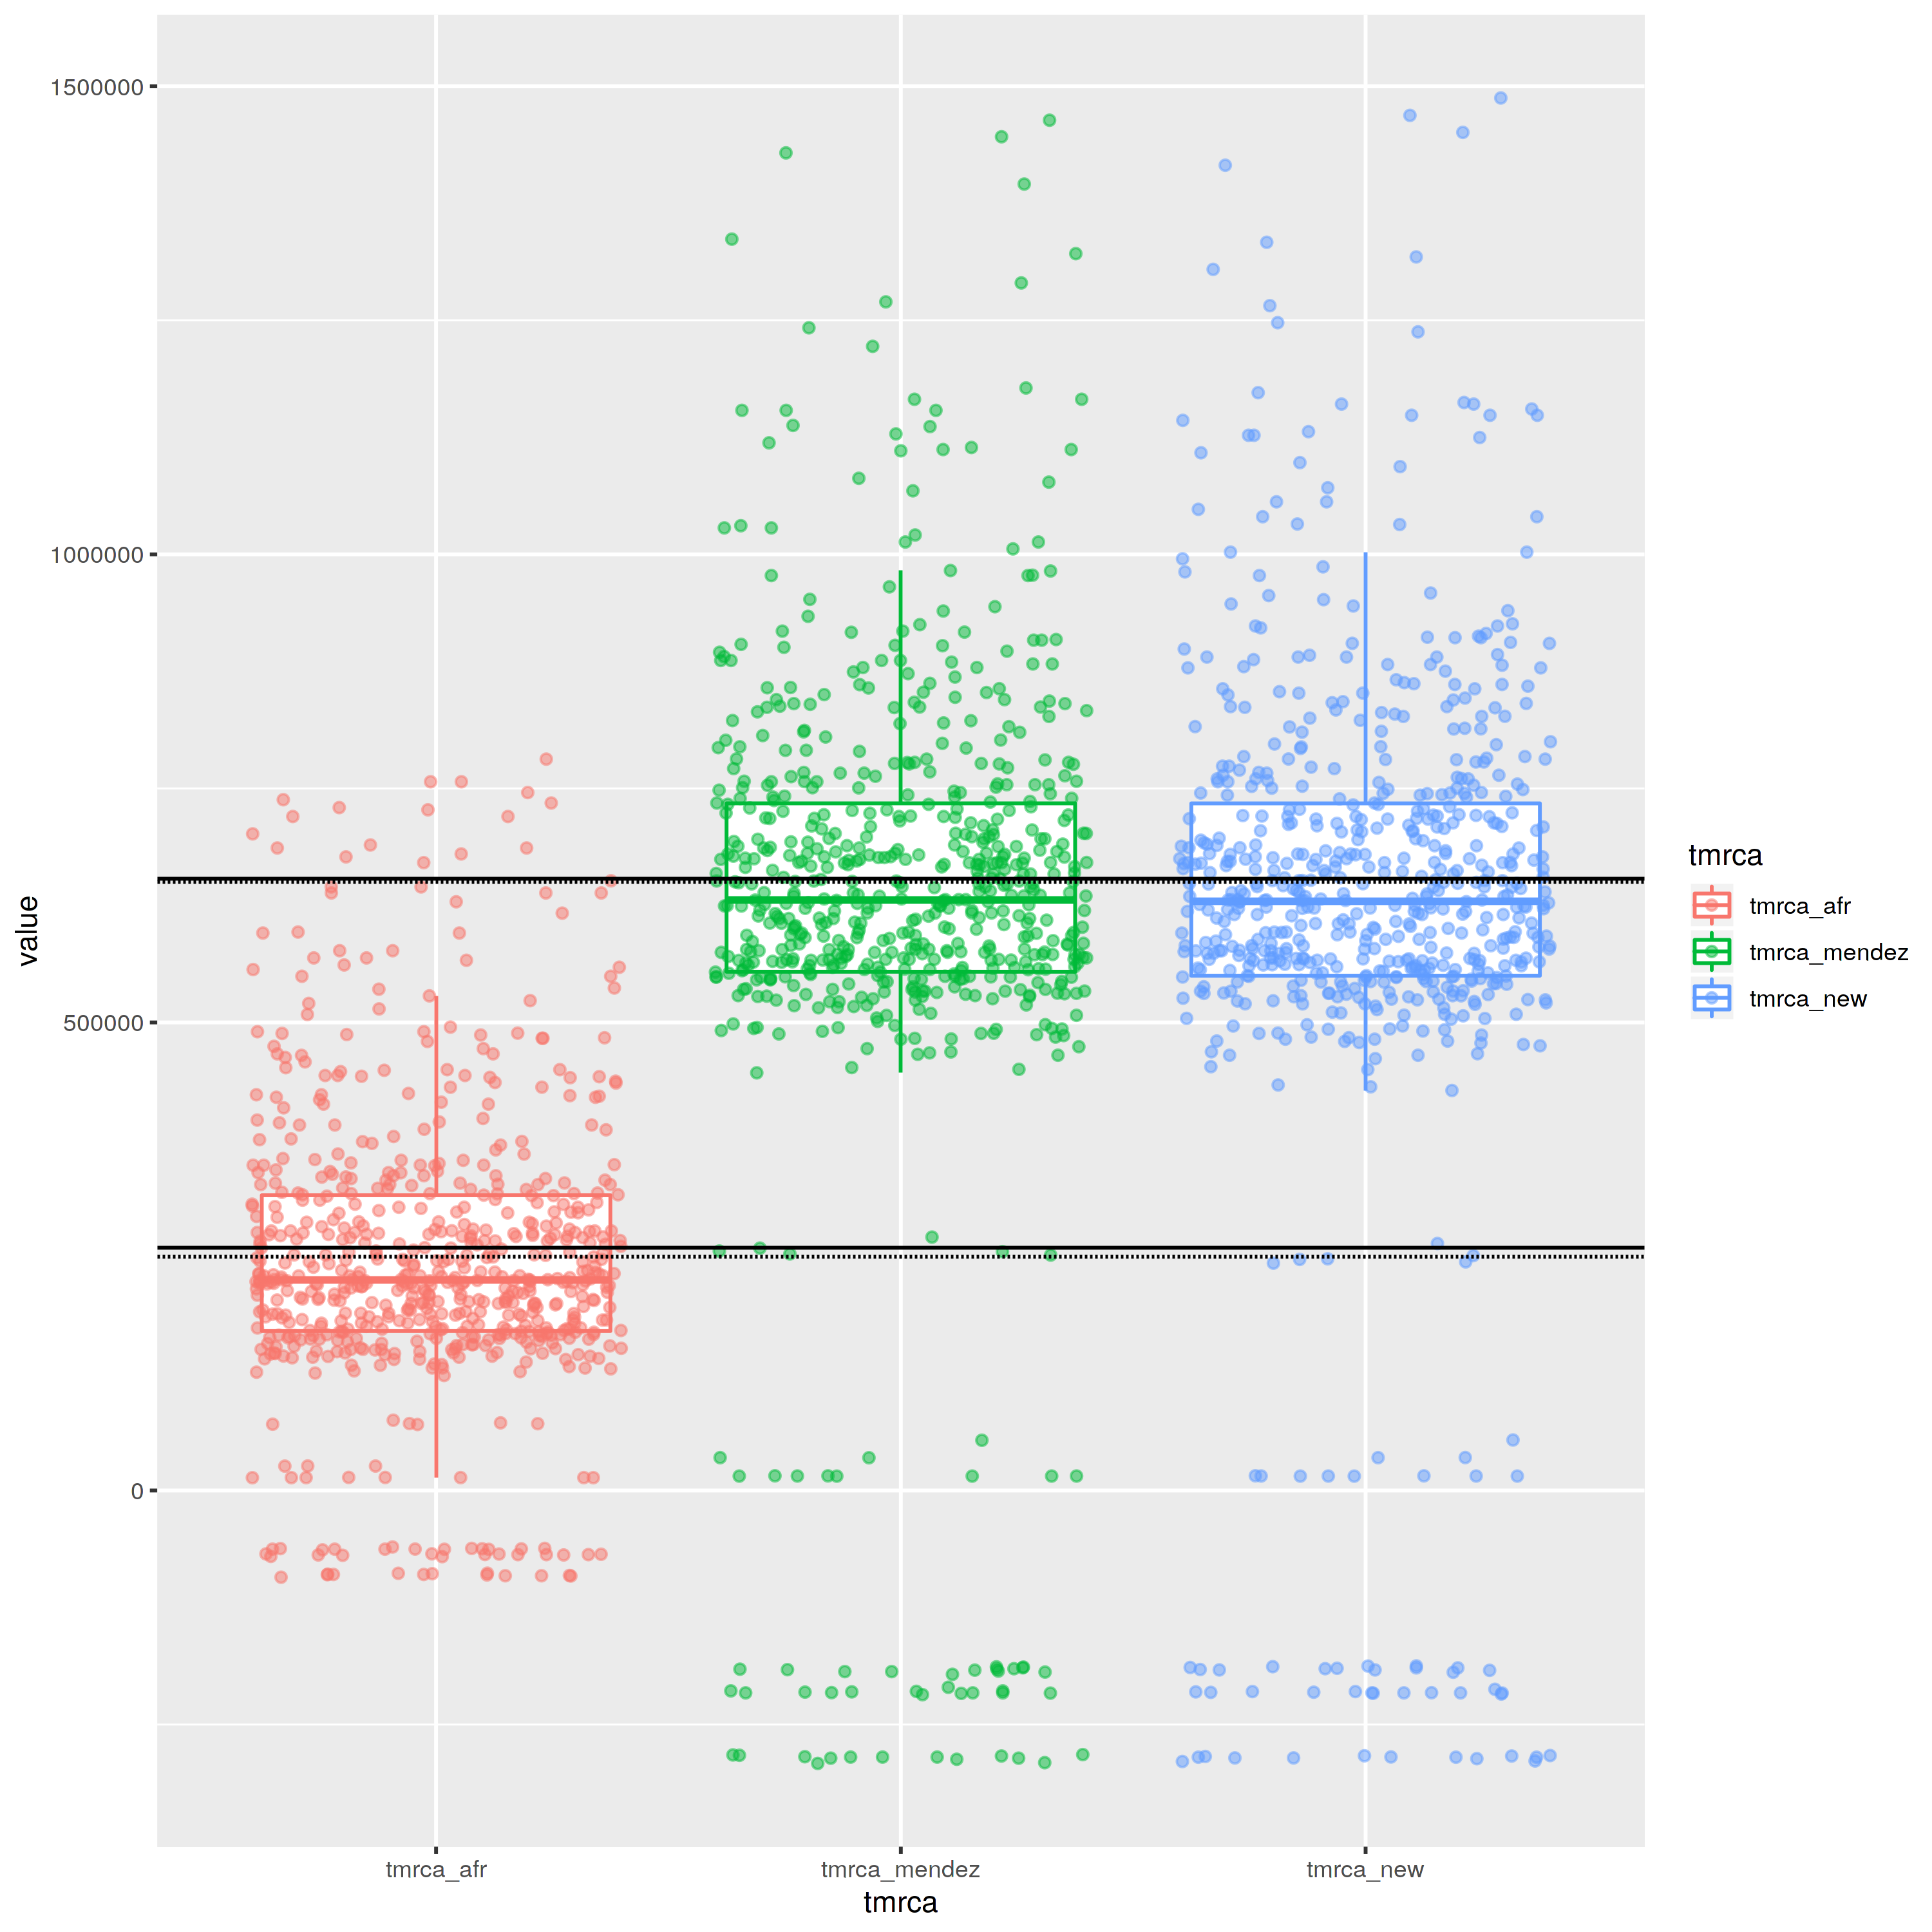

In [14]:
est_df %>%
ggplot(aes(tmrca, value, color = tmrca)) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(alpha = 1/2) +
    geom_hline(yintercept = c(250000, 650000), linetype = 2) +
    geom_hline(yintercept = true_df %>% group_by(set) %>% summean %>% .$value)

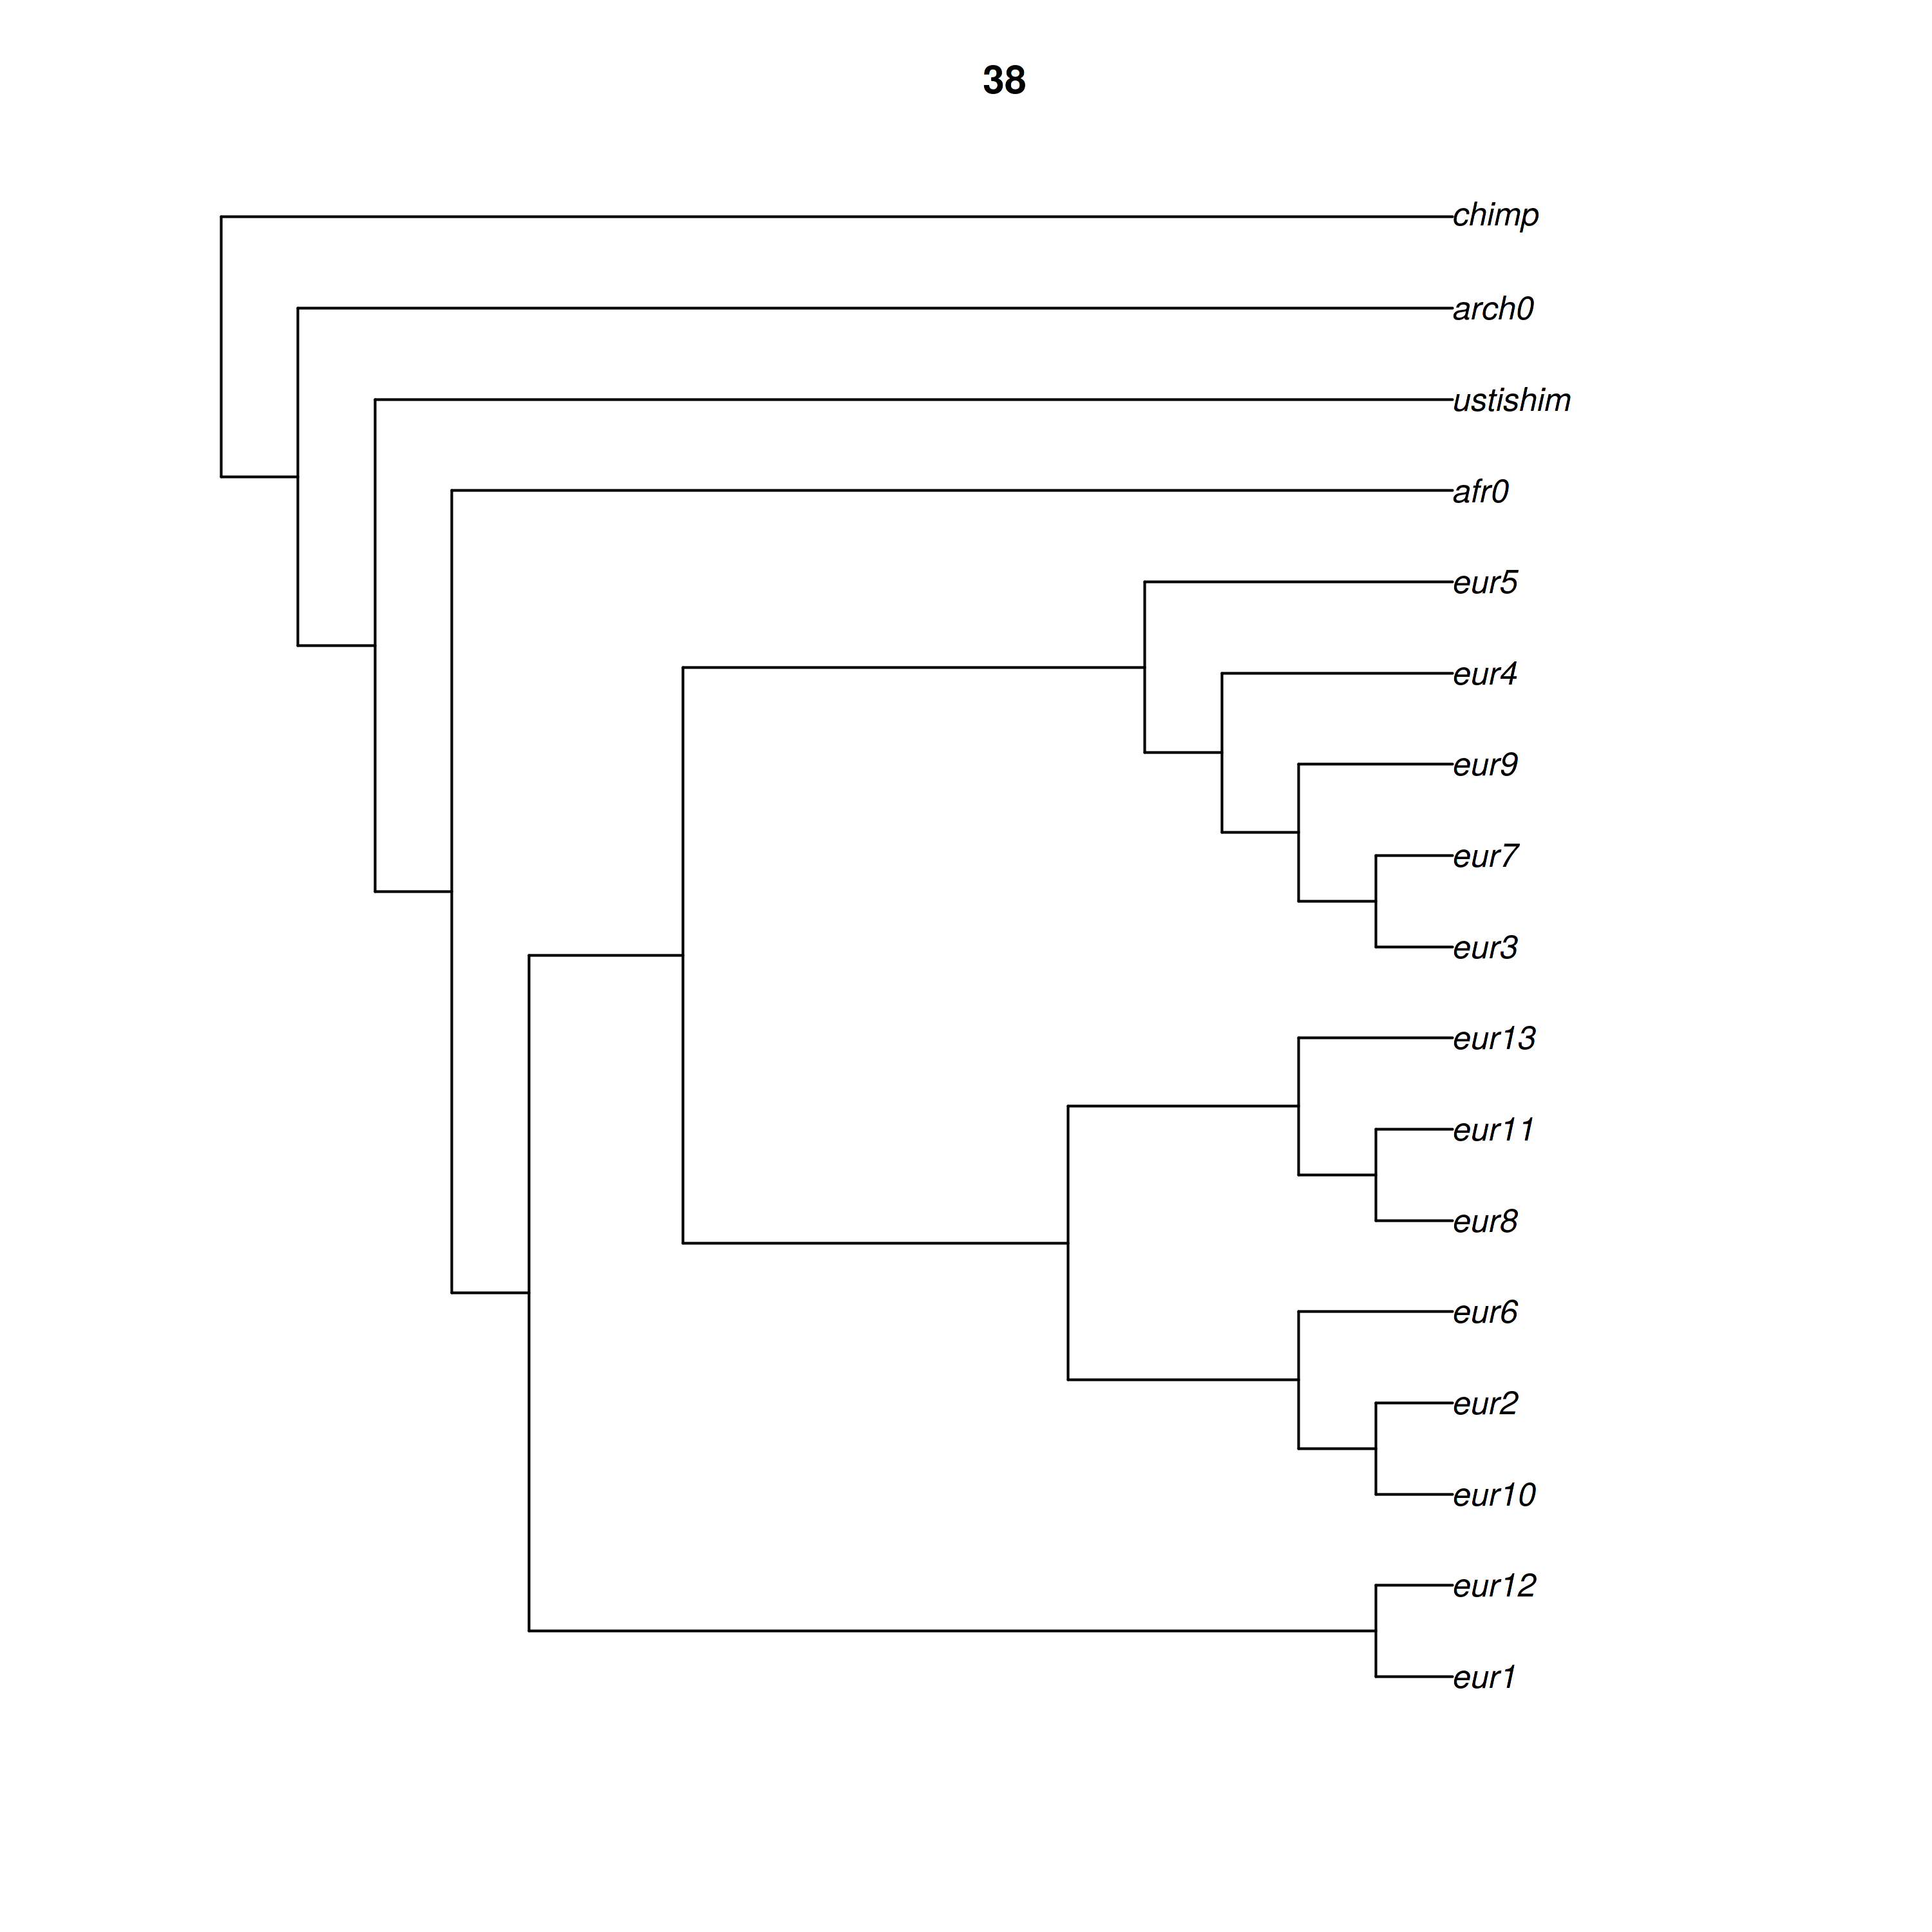

In [18]:
set_dim(10, 10)

i <- 38
aln <- read.phyDat(glue("../test/out_{i}.fa"), format = "fasta")

tree <- midpoint.root(NJ(dist.ml(aln)))

plot(tree, use.edge.length = FALSE, main = i)